[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1R0wylNL-Vr2IizmliBBh92L0yRcXDGCZ/view?usp=sharing)

# Simple VAE Tutorial
This notebook demonstrates how to build and train a Variational Autoencoder (VAE) on the MNIST dataset using TensorFlow and Keras.

## 1. Install and Import Dependencies

In [1]:
!pip install --quiet tensorflow matplotlib numpy

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


## 2. Load and Preprocess the MNIST Dataset

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.astype('float32') / 255.0
train_images = np.expand_dims(train_images, -1)

BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 3. Define the Encoder

In [3]:
latent_dim = 2

encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    401,920 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      1,026 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      1,026 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 403,972 (1.54 MB)

 Trainable params: 403,972 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Define the Decoder

In [4]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation='relu')(latent_inputs)
x = layers.Dense(28 * 28, activation='sigmoid')(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       402,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403,728 (1.54 MB)

 Trainable params: 403,728 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Define the VAE Model

In [5]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer, **kwargs):
        super(VAE, self).compile(**kwargs)
        self.optimizer = optimizer
        self.loss_metric = tf.keras.metrics.Mean(name='loss')
        self.recon_metric = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_metric = tf.keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.loss_metric, self.recon_metric, self.kl_metric]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * 28 * 28
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.loss_metric.update_state(total_loss)
        self.recon_metric.update_state(reconstruction_loss)
        self.kl_metric.update_state(kl_loss)
        return {
            'loss': self.loss_metric.result(),
            'reconstruction_loss': self.recon_metric.result(),
            'kl_loss': self.kl_metric.result()
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())


## 6. Train the VAE

In [6]:
EPOCHS = 30

history = vae.fit(train_dataset, epochs=EPOCHS)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - kl_loss: 10.6741 - loss: 233.4991 - reconstruction_loss: 222.8250
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 3.1063 - loss: 167.8000 - reconstruction_loss: 164.6937
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.1987 - loss: 162.6341 - reconstruction_loss: 159.4355
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.2719 - loss: 159.7415 - reconstruction_loss: 156.4696
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.3107 - loss: 158.4449 - reconstruction_loss: 155.1342
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 3.3870 - loss: 156.8220 - reconstruction_loss: 153.4350
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.4427 - loss: 155.5215 - reconstruction_loss: 152.0787
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.5052 - loss: 154.2556 - reconstruction_loss: 150.7504
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

## 7. Visualize Latent Space

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━

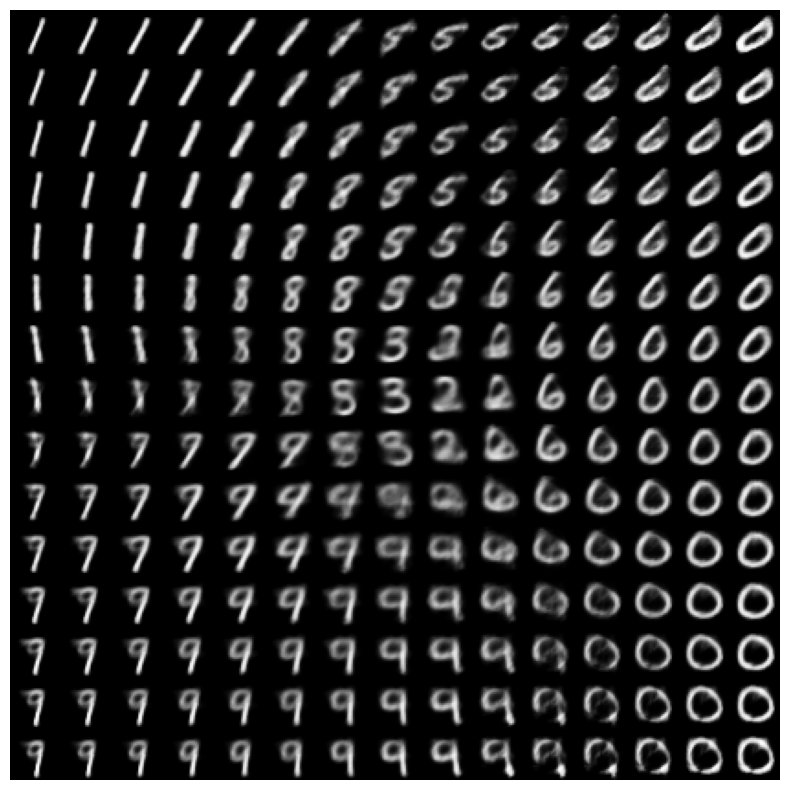

In [7]:
# Display a 2D manifold of digits by sampling latent space
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size
        ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.show()
